## In this notebook, we use Care for pair wise training. Q2.
## CM02: Q0_o, Q1_o, Q2_o, Q3_o, Q4_o, Q4_i, Q3_i, Q2_i, Q1_i, Q0_i
## CM03: Q0_i, Q1_i, Q2_i, Q3_i, Q4_i, Q4_o, Q3_o, Q2_o, Q1_o, Q0_o

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE
import glob
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
import copy


Using TensorFlow backend.


## Load Input and Output Data 

In [2]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print(len(imgs))
print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

10
Typical shape: (70, 896, 576)
Typical datatype: float64


## Take only the -21:-14  z-slices as input from CM02

In [3]:
X_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][-21:-14, ...]
    X_CM02.append(temp)
print(X_CM02[5].shape)

(7, 896, 576)


## Take only the 14:21 z-slices as output from CM02

In [4]:
Y_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][14:21, ...]
    Y_CM02.append(temp)
print(Y_CM02[5].shape)

(7, 896, 576)


## Load images from CM03

In [5]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

Typical shape: (70, 896, 576)
Typical datatype: float64


## Take only the 14:21 z-slices from CM03 as input

In [6]:
X_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][14:21, ...]
    X_CM03.append(temp)
print(X_CM03[5].shape)

(7, 896, 576)


## Take only the -21:-14 z-slices from CM03 as output

In [7]:
Y_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][-21:-14, ...]
    Y_CM03.append(temp)
print(Y_CM03[5].shape)

(7, 896, 576)


## Combine X_CM02 and X_CM03

In [8]:
imgsX=X_CM02+X_CM03
print(len(imgsX))
print(imgsX[5].shape)

20
(7, 896, 576)


In [9]:
imgsY=Y_CM03+Y_CM02
print(len(imgsY))
print(imgsY[5].shape)

20
(7, 896, 576)


## Visualize the images 

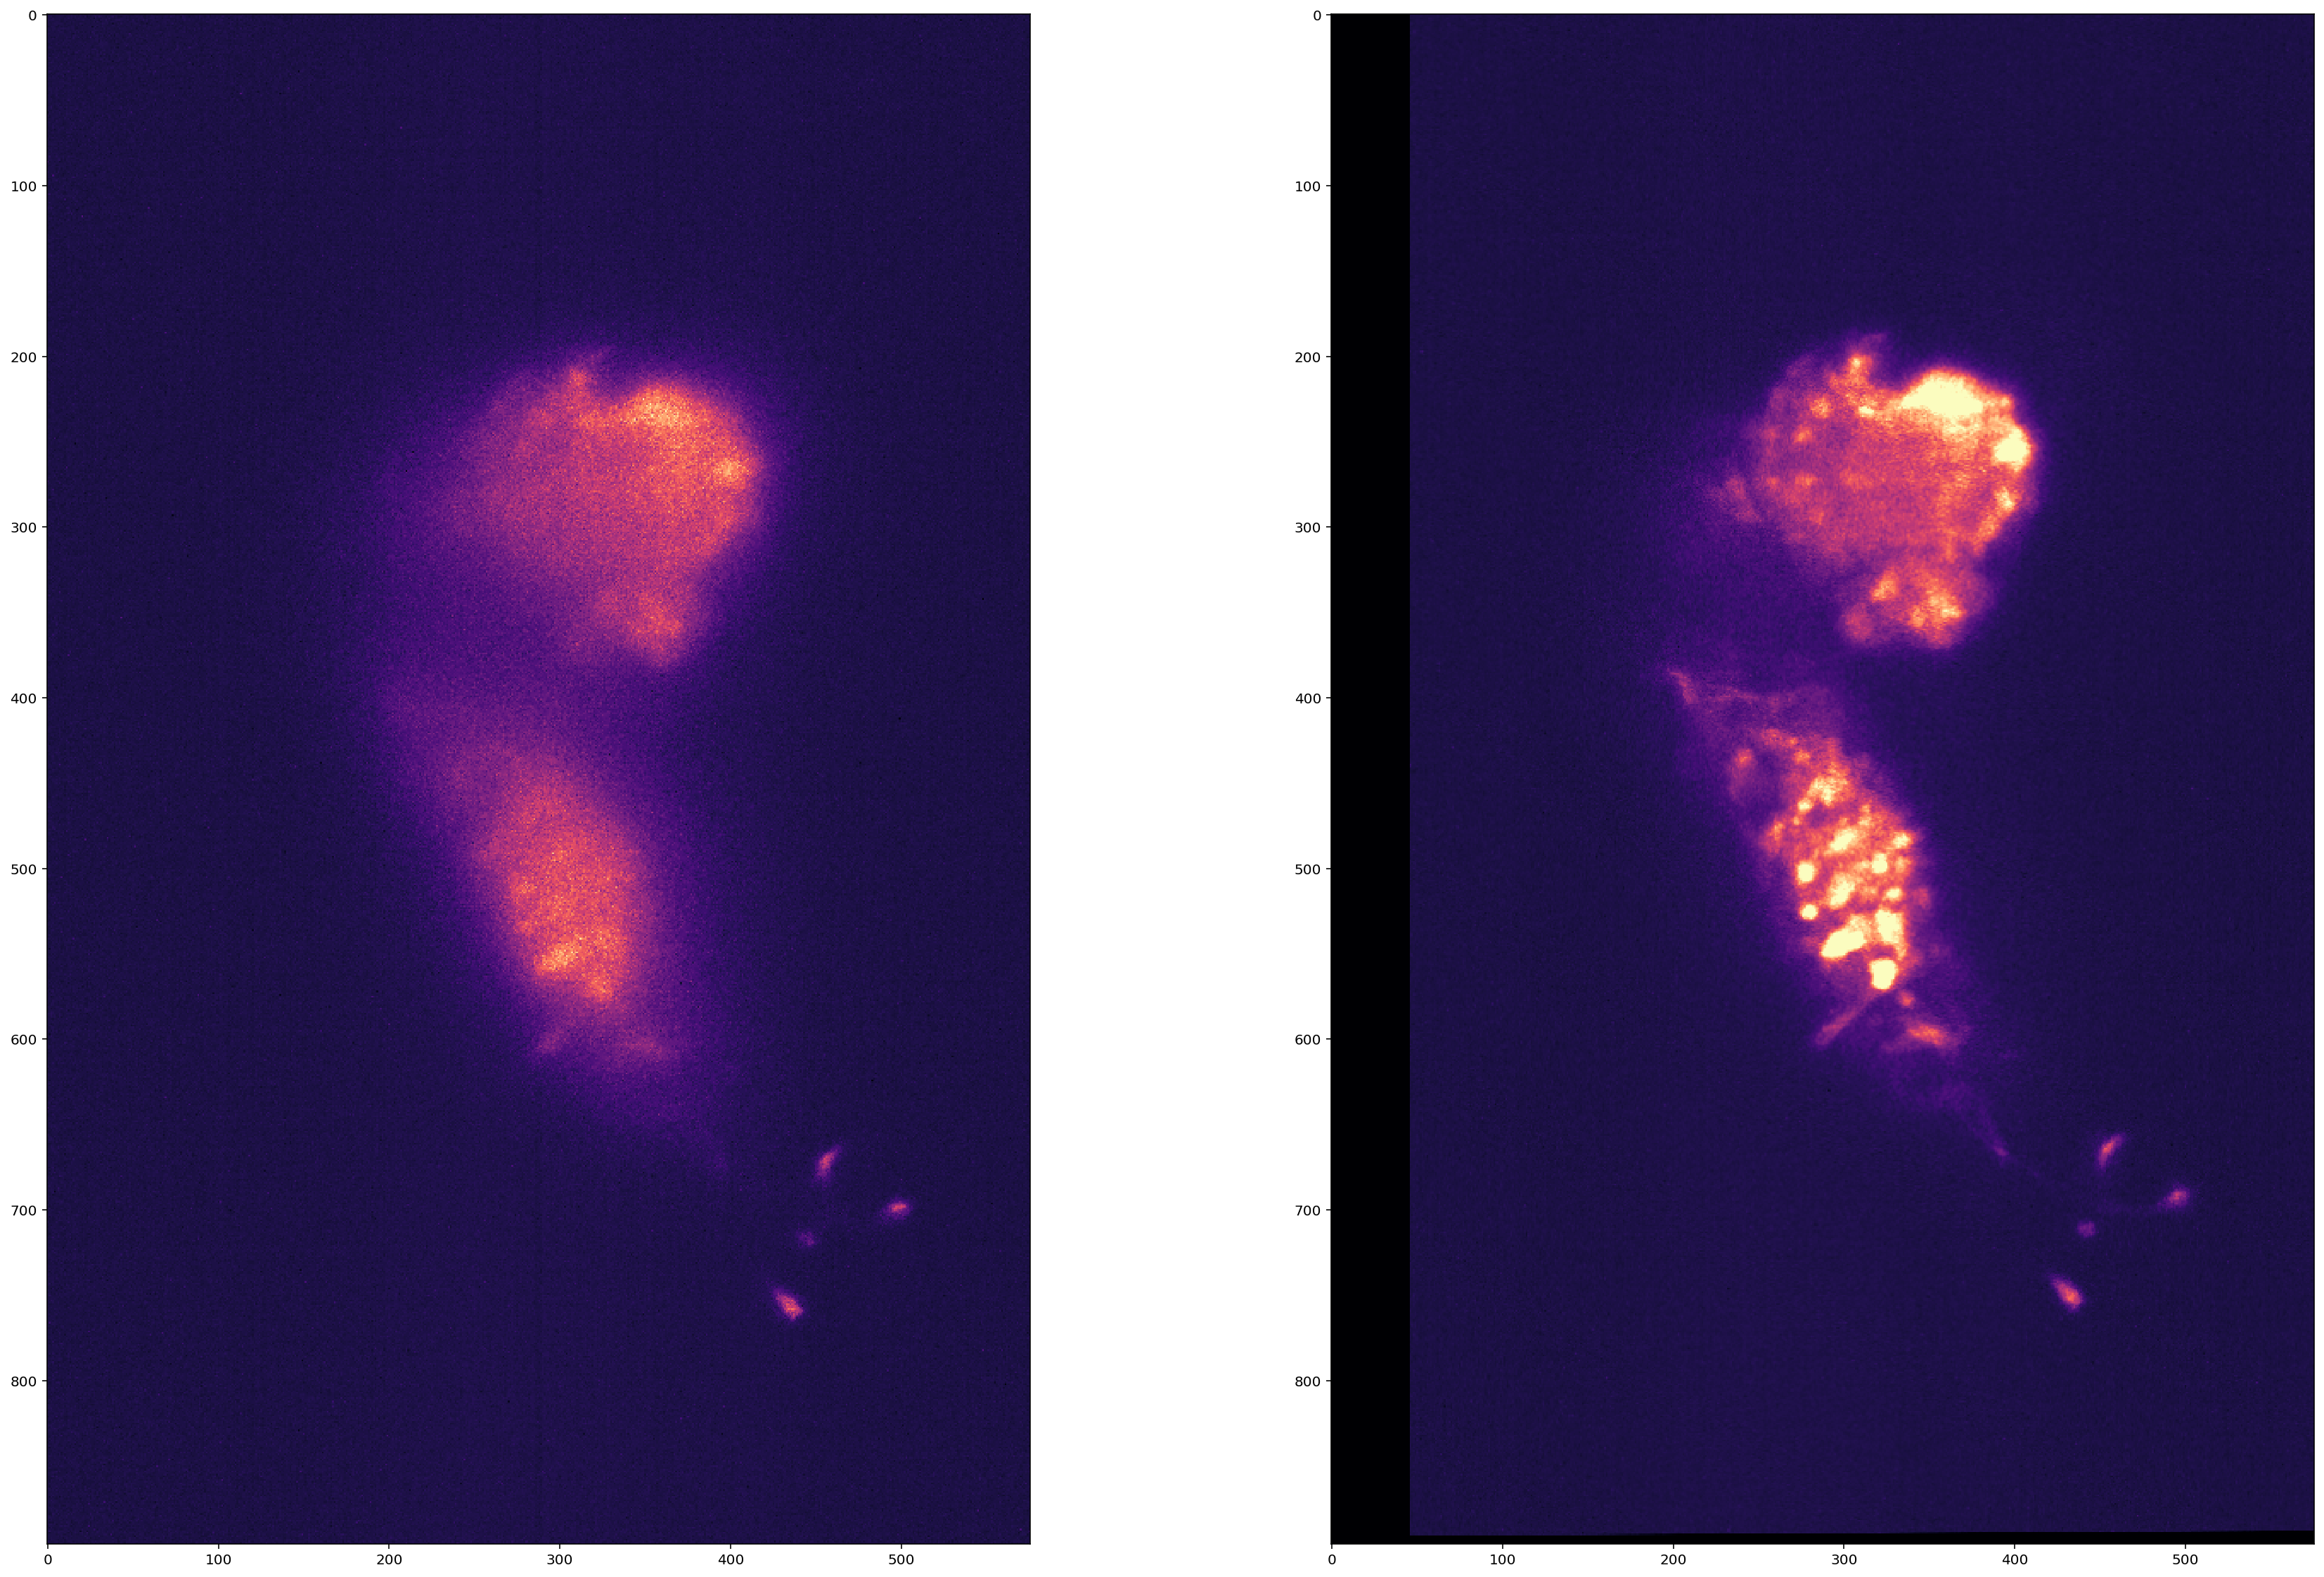

In [10]:
vmin=np.min(imgsX[14][5,...])
vmax=np.max(imgsX[14][5,...])
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(imgsX[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(imgsY[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.show()

## Since there is an artificial margin in the input and the output, we chop away the first and last 60 in the x dimension and in the y dimension

In [11]:
imgsX_chopped=[]
imgsY_chopped=[]
for i in range(len(imgsX)):
    imgsX_chopped.append(imgsX[i][:, 60:-60, 60:-60])
    imgsY_chopped.append(imgsY[i][:, 60:-60, 60:-60])

## Visualize the images again

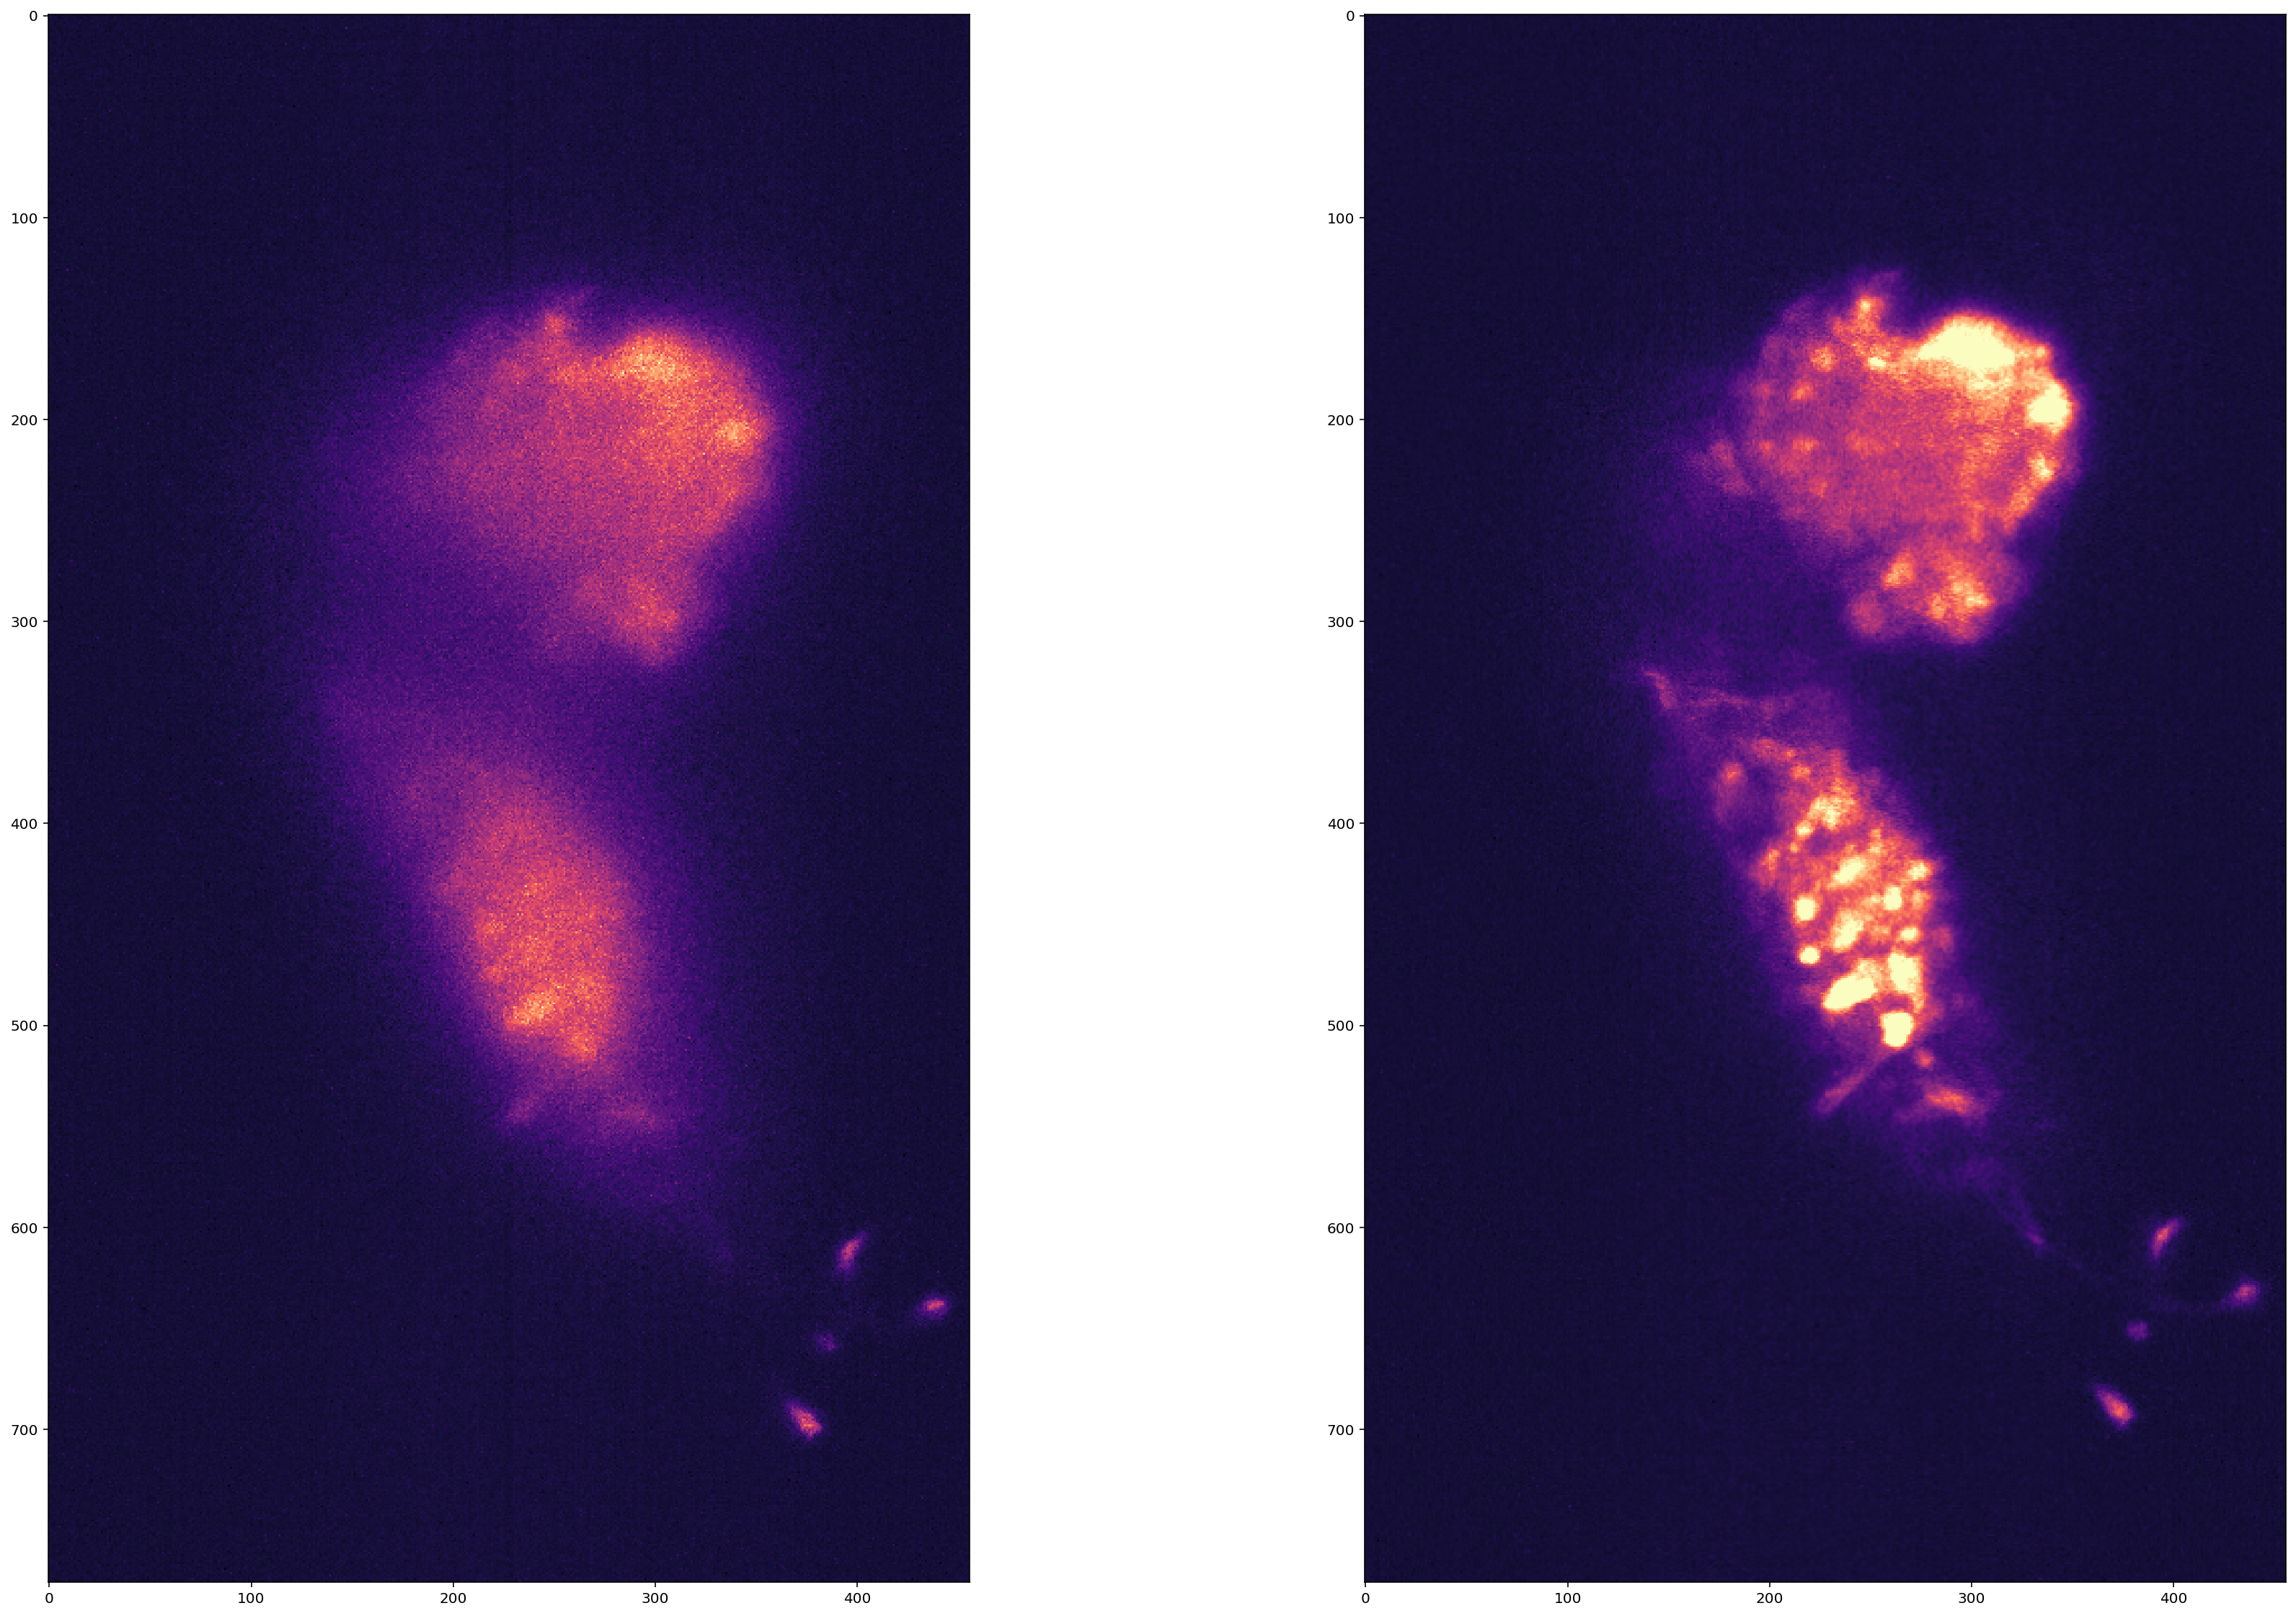

In [12]:
vmin=np.min(imgsX_chopped[15][5,...])
vmax=np.max(imgsX_chopped[15][5,...])
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(imgsX_chopped[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(imgsY_chopped[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.show()

## Also we must normalize the patches, prior to training !!

In [13]:
mean=np.mean(imgsX_chopped)
print(mean)
std=np.std(imgsX_chopped)
print(std)

120.80943111645092
42.888892159172904


## Create patches

In [14]:
imgsX_chopped=np.concatenate(imgsX_chopped, axis=0)
print(imgsX_chopped.shape)
imgsY_chopped=np.concatenate(imgsY_chopped, axis=0)
print(imgsY_chopped.shape)

(140, 776, 456)
(140, 776, 456)


In [15]:
combined=np.empty([np.shape(imgsX_chopped)[0], np.shape(imgsX_chopped)[1], np.shape(imgsX_chopped)[2], 2])
combined[..., 0]=imgsX_chopped
combined[..., 1]=imgsY_chopped
# Normalization Step
combined=(combined-mean)/std
print(combined.dtype)

float64


In [16]:
combinedList=[]
combinedList.append(combined)
print(len(combinedList))

1


## Augment is set to True

In [17]:
datagen = N2V_DataGenerator()
patches = datagen.generate_patches_from_list(combinedList, shape=(96, 96), augment=True)
print(patches.shape)

Generated patches: (35840, 96, 96, 2)
(35840, 96, 96, 2)


## Create train and validation pairs

In [18]:
X=patches[:-1000,..., 0]
X=X[..., np.newaxis]
Y=patches[:-1000, ..., 1]
Y=Y[..., np.newaxis]
X_val=patches[-1000:,..., 0]
X_val=X_val[..., np.newaxis]
Y_val=patches[-1000:, ..., 1]
Y_val=Y_val[..., np.newaxis]
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)
print("X_val shape: ", X_val.shape)
print("Y_val shape: ", Y_val.shape)

X shape:  (34840, 96, 96, 1)
Y shape:  (34840, 96, 96, 1)
X_val shape:  (1000, 96, 96, 1)
Y_val shape:  (1000, 96, 96, 1)


In [19]:
print("Datatype is:", patches[0, ..., 0].dtype)

Datatype is: float64


## Plot some examples from validation data

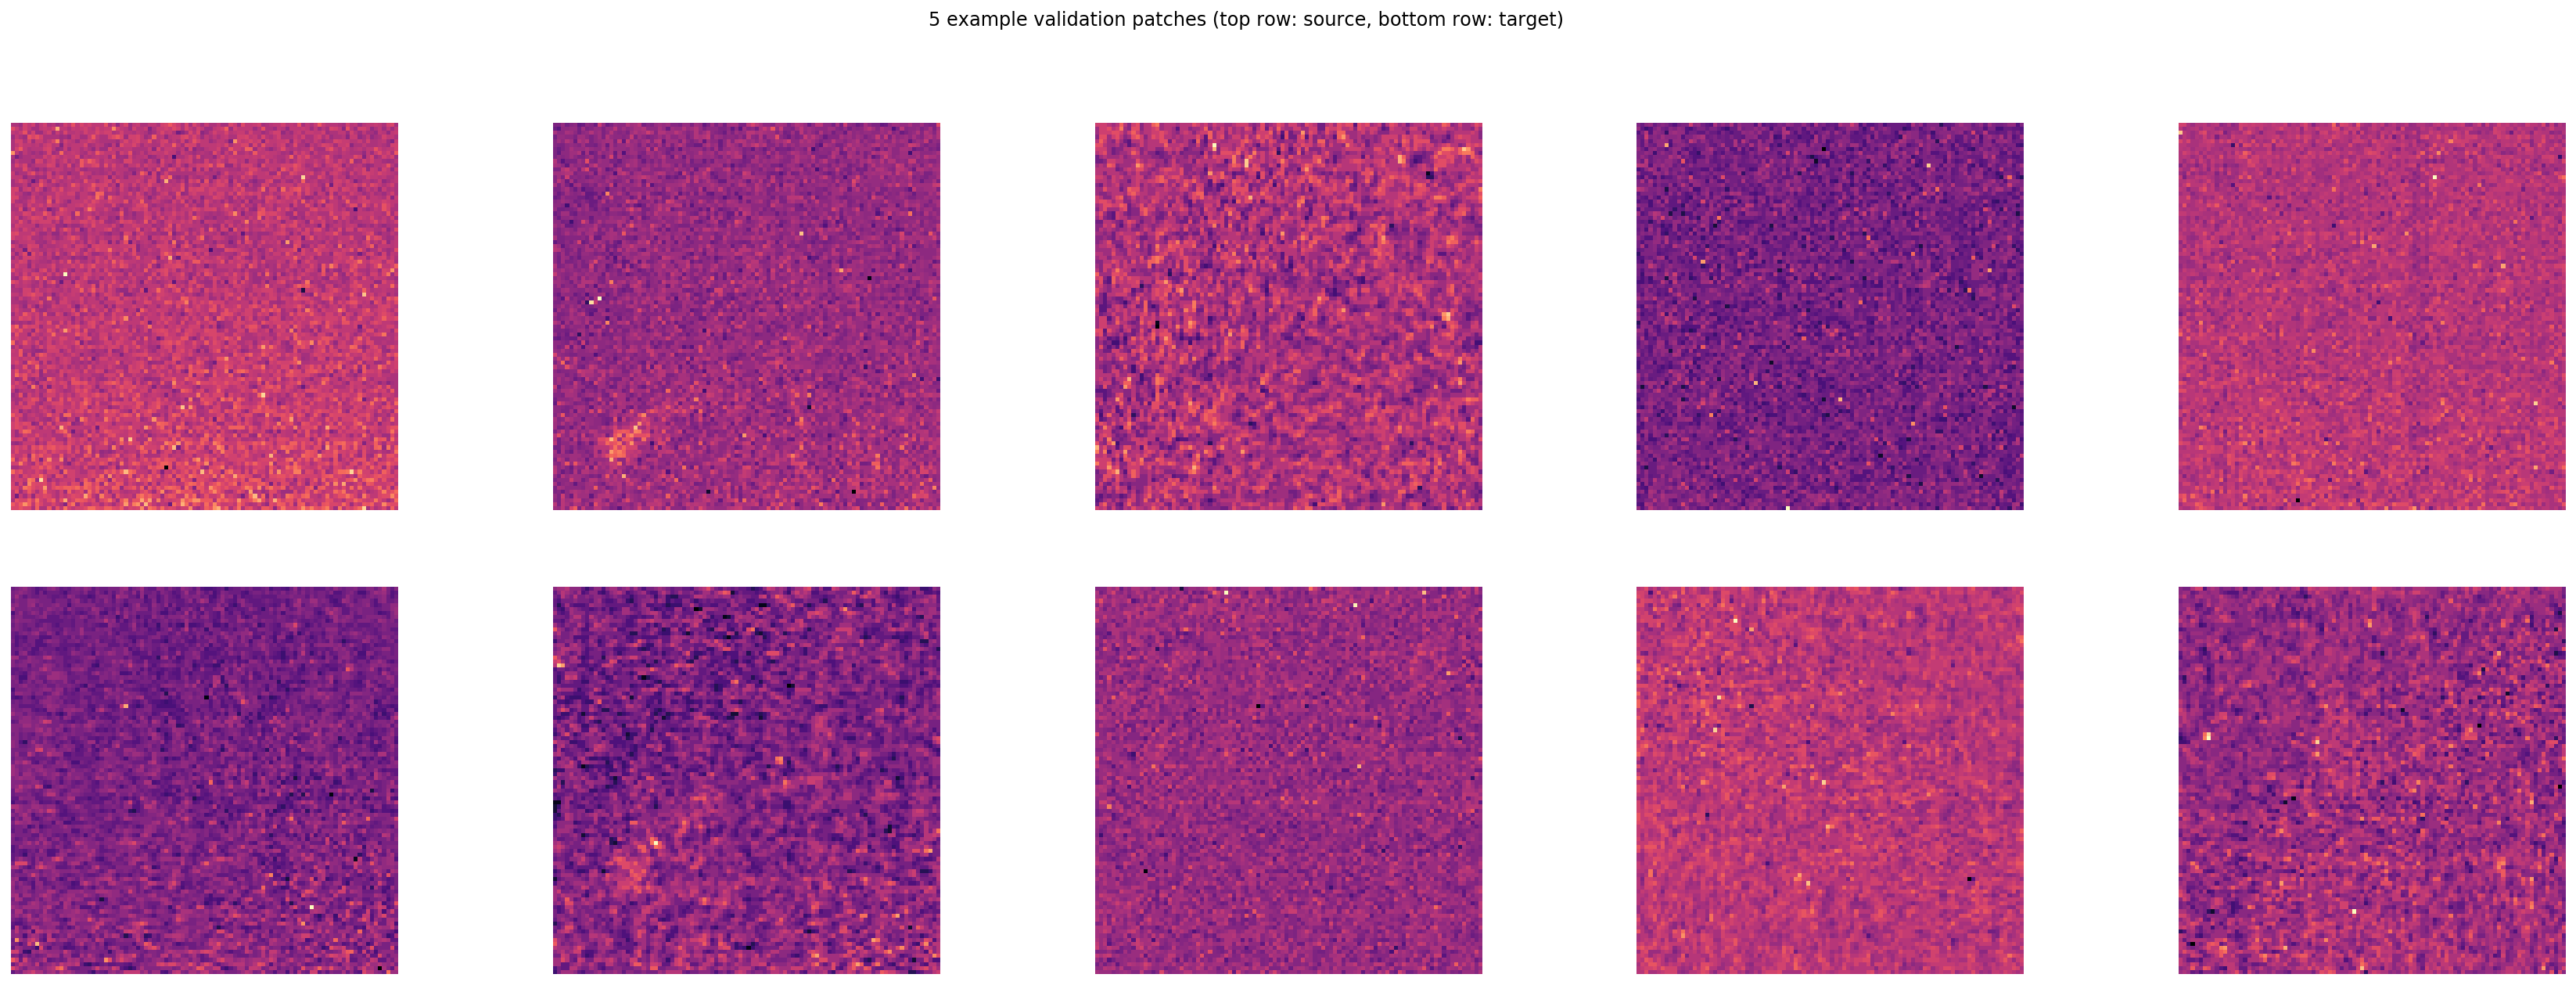

In [20]:
plt.figure(figsize=(30,10))
plot_some(X_val[300:305, ...],Y_val[300:305, ...])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

In [21]:
axes='SYXC'
n_channel_in=1
n_channel_out=1
config = Config(axes, n_channel_in, n_channel_out, probabilistic=False, train_steps_per_epoch=300, train_epochs=300, unet_n_first=64, unet_n_depth=3, unet_residual=False)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=300, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=300, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=3, unet_n_first=64, unet_residual=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 5,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 300,
 'train_steps_per_epoch': 300,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [22]:
model = CARE(config, 'care_2D_kellerlab_with_normalization_with_HandRegistration_float64_Q2_ne_300_es_300', basedir='models')

In [23]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

/home/lalit/Desktop/02_SoftwareExecutables/anaconda3/envs/n2vmultiviewEnv/lib/python3.6/site-packages/csbdeep/models/care_standard.py:259: UserWarning: small number of validation images (only 2.8% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100*frac_val))


Epoch 1/300
300/300 [==============================] - 30s 101ms/step - loss: 0.2505 - mse: 0.4428 - mae: 0.2505 - val_loss: 0.2387 - val_mse: 0.4181 - val_mae: 0.2387
Epoch 2/300
300/300 [==============================] - 28s 93ms/step - loss: 0.2282 - mse: 0.4098 - mae: 0.2282 - val_loss: 0.2407 - val_mse: 0.4234 - val_mae: 0.2407
Epoch 3/300
300/300 [==============================] - 28s 94ms/step - loss: 0.2301 - mse: 0.4260 - mae: 0.2301 - val_loss: 0.2323 - val_mse: 0.3973 - val_mae: 0.2323
Epoch 4/300
300/300 [==============================] - 28s 93ms/step - loss: 0.2281 - mse: 0.4144 - mae: 0.2281 - val_loss: 0.2324 - val_mse: 0.3944 - val_mae: 0.2324
Epoch 5/300
300/300 [==============================] - 28s 93ms/step - loss: 0.2167 - mse: 0.3757 - mae: 0.2167 - val_loss: 0.2352 - val_mse: 0.3858 - val_mae: 0.2352
Epoch 6/300
300/300 [==============================] - 28s 93ms/step - loss: 0.2275 - mse: 0.4222 - mae: 0.2275 - val_loss: 0.2251 - val_mse: 0.3764 - val_mae: 0.22

Epoch 50/300
300/300 [==============================] - 28s 92ms/step - loss: 0.2085 - mse: 0.3705 - mae: 0.2085 - val_loss: 0.2194 - val_mse: 0.3534 - val_mae: 0.2194
Epoch 51/300
300/300 [==============================] - 28s 94ms/step - loss: 0.2161 - mse: 0.3842 - mae: 0.2161 - val_loss: 0.2182 - val_mse: 0.3597 - val_mae: 0.2182
Epoch 52/300
300/300 [==============================] - 28s 94ms/step - loss: 0.2107 - mse: 0.3625 - mae: 0.2107 - val_loss: 0.2176 - val_mse: 0.3555 - val_mae: 0.2176
Epoch 53/300
300/300 [==============================] - 28s 93ms/step - loss: 0.2187 - mse: 0.3984 - mae: 0.2187 - val_loss: 0.2173 - val_mse: 0.3542 - val_mae: 0.2173
Epoch 54/300
300/300 [==============================] - 28s 93ms/step - loss: 0.2115 - mse: 0.3836 - mae: 0.2115 - val_loss: 0.2196 - val_mse: 0.3776 - val_mae: 0.2196
Epoch 55/300
300/300 [==============================] - 28s 93ms/step - loss: 0.2026 - mse: 0.3487 - mae: 0.2026 - val_loss: 0.2167 - val_mse: 0.3654 - val_mae:

300/300 [==============================] - 28s 94ms/step - loss: 0.2041 - mse: 0.3361 - mae: 0.2041 - val_loss: 0.2115 - val_mse: 0.3397 - val_mae: 0.2115
Epoch 98/300
300/300 [==============================] - 28s 93ms/step - loss: 0.2006 - mse: 0.3490 - mae: 0.2006 - val_loss: 0.2109 - val_mse: 0.3433 - val_mae: 0.2109
Epoch 99/300
300/300 [==============================] - 28s 94ms/step - loss: 0.2053 - mse: 0.3713 - mae: 0.2053 - val_loss: 0.2117 - val_mse: 0.3379 - val_mae: 0.2117
Epoch 100/300
300/300 [==============================] - 28s 94ms/step - loss: 0.1984 - mse: 0.3320 - mae: 0.1984 - val_loss: 0.2114 - val_mse: 0.3369 - val_mae: 0.2114
Epoch 101/300
300/300 [==============================] - 28s 93ms/step - loss: 0.1969 - mse: 0.3316 - mae: 0.1969 - val_loss: 0.2112 - val_mse: 0.3437 - val_mae: 0.2112
Epoch 102/300
300/300 [==============================] - 28s 93ms/step - loss: 0.2097 - mse: 0.3649 - mae: 0.2097 - val_loss: 0.2140 - val_mse: 0.3352 - val_mae: 0.2140
Ep

300/300 [==============================] - 28s 93ms/step - loss: 0.2036 - mse: 0.3468 - mae: 0.2036 - val_loss: 0.2105 - val_mse: 0.3331 - val_mae: 0.2105
Epoch 145/300
300/300 [==============================] - 28s 94ms/step - loss: 0.2018 - mse: 0.3256 - mae: 0.2018 - val_loss: 0.2100 - val_mse: 0.3366 - val_mae: 0.2100
Epoch 146/300
300/300 [==============================] - 28s 94ms/step - loss: 0.2031 - mse: 0.3438 - mae: 0.2031 - val_loss: 0.2098 - val_mse: 0.3388 - val_mae: 0.2098
Epoch 147/300
300/300 [==============================] - 28s 94ms/step - loss: 0.2015 - mse: 0.3439 - mae: 0.2015 - val_loss: 0.2103 - val_mse: 0.3376 - val_mae: 0.2103
Epoch 148/300
300/300 [==============================] - 28s 93ms/step - loss: 0.2047 - mse: 0.3412 - mae: 0.2047 - val_loss: 0.2104 - val_mse: 0.3338 - val_mae: 0.2104
Epoch 149/300
300/300 [==============================] - 28s 93ms/step - loss: 0.2060 - mse: 0.3662 - mae: 0.2060 - val_loss: 0.2108 - val_mse: 0.3333 - val_mae: 0.2108


Epoch 191/300
300/300 [==============================] - 28s 93ms/step - loss: 0.1993 - mse: 0.3349 - mae: 0.1993 - val_loss: 0.2101 - val_mse: 0.3344 - val_mae: 0.2101
Epoch 192/300
300/300 [==============================] - 28s 94ms/step - loss: 0.2037 - mse: 0.3437 - mae: 0.2037 - val_loss: 0.2101 - val_mse: 0.3347 - val_mae: 0.2101
Epoch 193/300
300/300 [==============================] - 28s 93ms/step - loss: 0.2042 - mse: 0.3419 - mae: 0.2042 - val_loss: 0.2101 - val_mse: 0.3347 - val_mae: 0.2101
Epoch 194/300
300/300 [==============================] - 28s 94ms/step - loss: 0.2046 - mse: 0.3576 - mae: 0.2046 - val_loss: 0.2102 - val_mse: 0.3342 - val_mae: 0.2102
Epoch 195/300
300/300 [==============================] - 28s 93ms/step - loss: 0.1975 - mse: 0.3253 - mae: 0.1975 - val_loss: 0.2101 - val_mse: 0.3345 - val_mae: 0.2101
Epoch 196/300
300/300 [==============================] - 28s 94ms/step - loss: 0.1988 - mse: 0.3344 - mae: 0.1988 - val_loss: 0.2101 - val_mse: 0.3346 - va

300/300 [==============================] - 28s 94ms/step - loss: 0.1964 - mse: 0.3313 - mae: 0.1964 - val_loss: 0.2101 - val_mse: 0.3345 - val_mae: 0.2101
Epoch 238/300
300/300 [==============================] - 28s 93ms/step - loss: 0.2008 - mse: 0.3396 - mae: 0.2008 - val_loss: 0.2101 - val_mse: 0.3345 - val_mae: 0.2101

Epoch 00238: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Epoch 239/300
300/300 [==============================] - 28s 95ms/step - loss: 0.2042 - mse: 0.3378 - mae: 0.2042 - val_loss: 0.2101 - val_mse: 0.3345 - val_mae: 0.2101
Epoch 240/300
300/300 [==============================] - 28s 92ms/step - loss: 0.2019 - mse: 0.3451 - mae: 0.2019 - val_loss: 0.2101 - val_mse: 0.3345 - val_mae: 0.2101
Epoch 241/300
300/300 [==============================] - 28s 93ms/step - loss: 0.1964 - mse: 0.3283 - mae: 0.1964 - val_loss: 0.2101 - val_mse: 0.3345 - val_mae: 0.2101
Epoch 242/300
300/300 [==============================] - 28s 93ms/step - loss: 0.2012 -

300/300 [==============================] - 28s 94ms/step - loss: 0.1987 - mse: 0.3404 - mae: 0.1987 - val_loss: 0.2101 - val_mse: 0.3345 - val_mae: 0.2101
Epoch 284/300
300/300 [==============================] - 28s 93ms/step - loss: 0.2029 - mse: 0.3411 - mae: 0.2029 - val_loss: 0.2101 - val_mse: 0.3345 - val_mae: 0.2101
Epoch 285/300
300/300 [==============================] - 28s 94ms/step - loss: 0.1994 - mse: 0.3296 - mae: 0.1994 - val_loss: 0.2101 - val_mse: 0.3345 - val_mae: 0.2101
Epoch 286/300
300/300 [==============================] - 28s 93ms/step - loss: 0.2060 - mse: 0.3502 - mae: 0.2060 - val_loss: 0.2101 - val_mse: 0.3345 - val_mae: 0.2101
Epoch 287/300
300/300 [==============================] - 28s 93ms/step - loss: 0.1993 - mse: 0.3152 - mae: 0.1993 - val_loss: 0.2101 - val_mse: 0.3345 - val_mae: 0.2101
Epoch 288/300
300/300 [==============================] - 28s 93ms/step - loss: 0.1950 - mse: 0.3132 - mae: 0.1950 - val_loss: 0.2101 - val_mse: 0.3345 - val_mae: 0.2101


['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


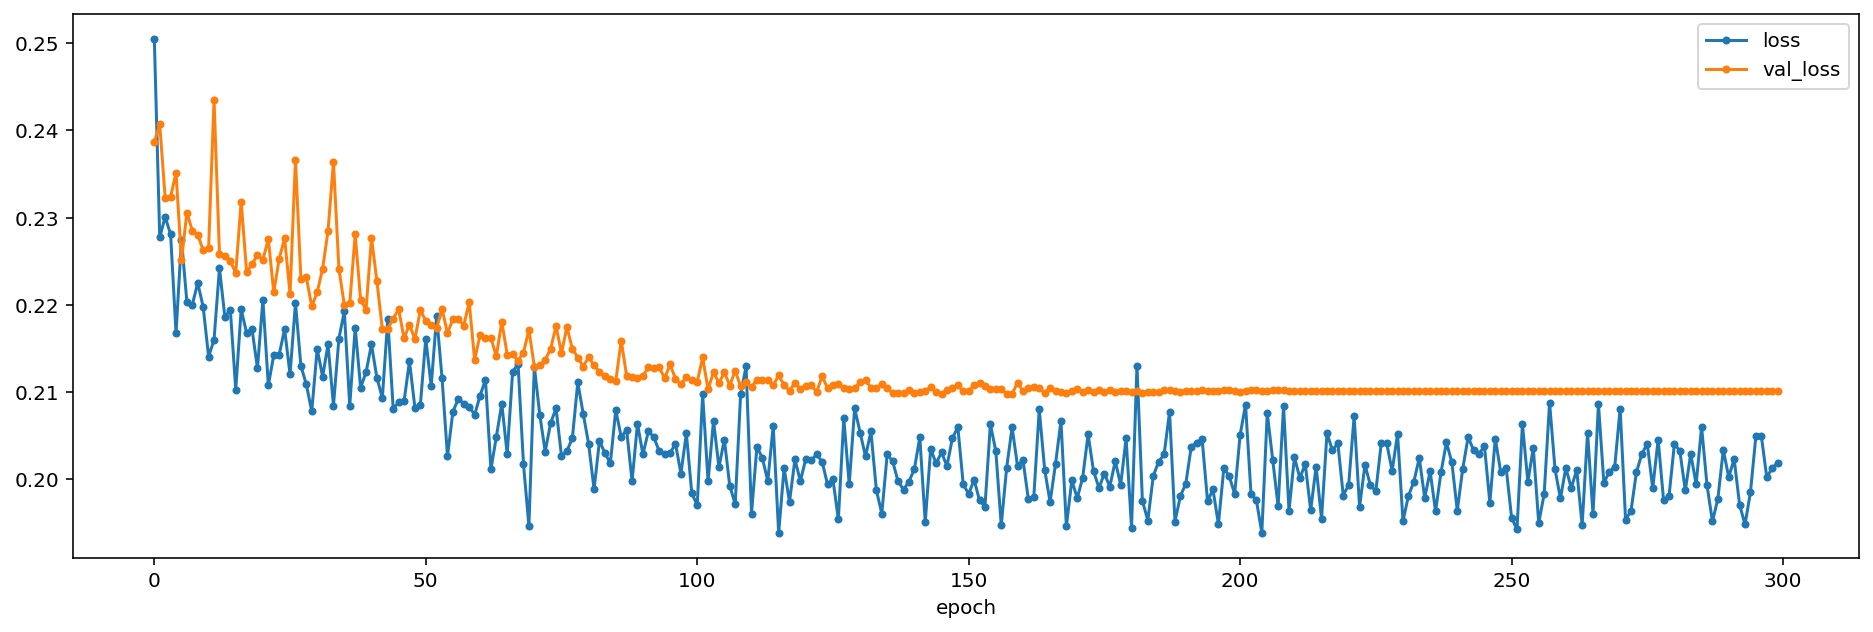

In [24]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);